# Comparative Analysis

---

## Index

1. [Loading Data](#loading)
2. [Parsing Human Scores](#parse)
3. [Normalize Columns](#normie)
4. [Llama Scores](#llama)
5. [Comparative Analysis](#comparative)
6. [Disagreement Table](#disagreement)

In [1]:
import re, json, time, random, statistics as stats
from typing import Dict, Any, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')  # follow the auth prompt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the Datasets <a name="loading"></a>


In [6]:
llamaPath = '/content/drive/MyDrive/mvp/finalScores20251024-000950.csv'
recruiterPath = '/content/drive/MyDrive/mvp/candidates_v2_recruiter_graded.csv'
ownerPath = '/content/drive/MyDrive/mvp/candidates_v2_service_owner_graded.csv'
llamaScores = pd.read_csv(llamaPath)
recruiter_raw = pd.read_csv(recruiterPath)
service_owner_raw = pd.read_csv(ownerPath)
print(llamaScores.shape, recruiter_raw.shape, service_owner_raw.shape)


(50, 21) (50, 10) (50, 10)


In [5]:
llamaScores.columns

Index(['interview_id', 'cognitive_ability_score', 'experience_score',
       'problem_solving_score', 'reliability_score', 'professionalism_score',
       'communication_score', 'cognitive_ability_justification',
       'experience_justification', 'problem_solving_justification',
       'reliability_justification', 'professionalism_justification',
       'communication_justification', 'general_strengths',
       'general_weaknesses', 'general_summary', 'final_model_name',
       'final_prompt_version', 'final_temperature', 'final_latency_ms',
       'created_at'],
      dtype='object')

## Parse human scores (split score vs justification) <a name="parse"></a>


In [7]:
METRICS_HUMAN = ["Cognitive ability", "Experience", "Problem Solving", "Reliability", "Professionalism", "Communication"]

def extract_score_and_justification(df, metric_cols):
    """For each metric col like 'Cognitive ability', create:
       {snake}_score (float) and {snake}_justification (str)."""
    out = df.copy()
    for metric in metric_cols:
        base = metric.lower().replace(" ", "_")
        score_col = f"{base}_score"
        just_col = f"{base}_justification"
        # 1) numeric score
        out[score_col] = out[metric].str.extract(r'(\d+)').astype(float)
        # 2) justification (remove leading "N – " or "N - ")
        out[just_col] = out[metric].str.replace(r'^\s*\d+\s*[–-]\s*', '', regex=True).str.strip()
    return out

recruiter = extract_score_and_justification(recruiter_raw, METRICS_HUMAN)
service_owner = extract_score_and_justification(service_owner_raw, METRICS_HUMAN)

# Keep standard columns
KEEP = ["interview_id", "candidate_id", "role_title"]
SCORE_COLS = [f"{m.lower().replace(' ', '_')}_score" for m in METRICS_HUMAN]
JUST_COLS  = [f"{m.lower().replace(' ', '_')}_justification" for m in METRICS_HUMAN]

recruiter = recruiter[KEEP + SCORE_COLS + JUST_COLS]
service_owner = service_owner[KEEP + SCORE_COLS + JUST_COLS]


In [12]:
recruiter.head(3)

,interview_id,candidate_id,role_title,cognitive_ability_score,experience_score,problem_solving_score,reliability_score,professionalism_score,communication_score,cognitive_ability_justification,experience_justification,problem_solving_justification,reliability_justification,professionalism_justification,communication_justification
0,intv_0001,cand_0001,Field Technician,4.0,5.0,6.0,5.0,6.0,4.0,Shows limited structured thinking; lacks insig...,Mentions work experience without quantifiable ...,Demonstrates partial reasoning; lacks measurab...,Weak demonstration of consistency or follow-th...,Language acceptable but lacks polish; would no...,Writing is uneven or unclear; needs stronger s...
1,intv_0002,cand_0002,Field Technician,4.0,5.0,6.0,5.0,6.0,4.0,Shows limited structured thinking; lacks insig...,Mentions work experience without quantifiable ...,Demonstrates partial reasoning; lacks measurab...,Weak demonstration of consistency or follow-th...,Language acceptable but lacks polish; would no...,Writing is uneven or unclear; needs stronger s...
2,intv_0003,cand_0003,Field Technician,4.0,5.0,6.0,5.0,6.0,4.0,Shows limited structured thinking; lacks insig...,Mentions work experience without quantifiable ...,Demonstrates partial reasoning; lacks measurab...,Weak demonstration of consistency or follow-th...,Language acceptable but lacks polish; would no...,Writing is uneven or unclear; needs stronger s...


In [11]:
service_owner.head(3)

,interview_id,candidate_id,role_title,cognitive_ability_score,experience_score,problem_solving_score,reliability_score,professionalism_score,communication_score,cognitive_ability_justification,experience_justification,problem_solving_justification,reliability_justification,professionalism_justification,communication_justification
0,intv_0001,cand_0001,Field Technician,5.0,6.0,5.0,4.0,5.0,4.0,Shows basic common sense but lacks depth or cl...,Mentions experience but not much proof they’ve...,Talks about solving problems but no clear exam...,Not enough evidence they’d show up daily and g...,Comes across okay but not someone I’d immediat...,Answer rambles or misses the point — not clear...
1,intv_0002,cand_0002,Field Technician,7.0,8.0,7.0,6.0,7.0,6.0,Shows basic common sense but lacks depth or cl...,Mentions experience but not much proof they’ve...,Talks about solving problems but no clear exam...,Not enough evidence they’d show up daily and g...,Comes across okay but not someone I’d immediat...,Answer rambles or misses the point — not clear...
2,intv_0003,cand_0003,Field Technician,7.0,8.0,7.0,6.0,7.0,6.0,Shows basic common sense but lacks depth or cl...,Mentions experience but not much proof they’ve...,Talks about solving problems but no clear exam...,Not enough evidence they’d show up daily and g...,Comes across okay but not someone I’d immediat...,Answer rambles or misses the point — not clear...


## Normalize Llama Columns <a name="normie"></a>


In [9]:
# If llama columns already match, you can skip this.
# Example mapping (edit if your column names differ):
LLAMA_RENAME = {
    "cognitive_ability_score": "cognitive_ability_score",
    "experience_score": "experience_score",
    "problem_solving_score": "problem_solving_score",
    "reliability_score": "reliability_score",
    "professionalism_score": "professionalism_score",
    "communication_score": "communication_score",
    "cognitive_ability_justification": "cognitive_ability_justification",
    "experience_justification": "experience_justification",
    "problem_solving_justification": "problem_solving_justification",
    "reliability_justification": "reliability_justification",
    "professionalism_justification": "professionalism_justification",
    "communication_justification": "communication_justification",
}

llamaScores = llamaScores.rename(columns=LLAMA_RENAME)

# Keep the essentials + metadata you care about
LLAMA_KEEP = KEEP + list(LLAMA_RENAME.values()) + [
    "final_model_name", "final_prompt_version", "final_temperature", "final_latency_ms", "created_at"
]
llamaScores = llamaScores[[c for c in LLAMA_KEEP if c in llamaScores.columns]]


In [13]:
llamaScores.head(3)

,interview_id,cognitive_ability_score,experience_score,problem_solving_score,reliability_score,professionalism_score,communication_score,cognitive_ability_justification,experience_justification,problem_solving_justification,reliability_justification,professionalism_justification,communication_justification,final_model_name,final_prompt_version,final_temperature,final_latency_ms,created_at
0,intv_0001,9,8,8,9,8,9,The candidate demonstrated exceptional cogniti...,The candidate has significant experience in th...,The candidate demonstrated effective problem-s...,The candidate demonstrated a strong commitment...,The candidate consistently demonstrated a prof...,"The candidate was an effective communicator, u...",meta-llama/Llama-3.1-8B-Instruct:novita,rewrite_v1,0.0,9573,2025-10-24T00:02:19.186352+00:00
1,intv_0002,9,8,8,9,8,9,The candidate demonstrated exceptional cogniti...,The candidate has extensive experience in the ...,The candidate demonstrated strong problem-solv...,The candidate consistently demonstrated a stro...,The candidate consistently displayed a profess...,The candidate consistently demonstrated excell...,meta-llama/Llama-3.1-8B-Instruct:novita,rewrite_v1,0.0,8013,2025-10-24T00:02:27.200074+00:00
2,intv_0003,9,8,8,9,9,8,The candidate demonstrates strong cognitive ab...,The candidate has relevant experience in the f...,The candidate demonstrates strong problem-solv...,The candidate consistently demonstrates reliab...,The candidate consistently demonstrates profes...,The candidate demonstrates effective communica...,meta-llama/Llama-3.1-8B-Instruct:novita,rewrite_v1,0.0,6297,2025-10-24T00:02:33.497558+00:00


## Llama-only analysis (scores, latency, correlations) <a name="llama"></a>

In [16]:
# Summary stats for scores
llama_scores_only = llamaScores[SCORE_COLS]
llama_score_summary = llama_scores_only.describe().T  # mean, std, min, max, etc.
print("LLAMA SCORE SUMMARY:\n", llama_score_summary)


LLAMA SCORE SUMMARY:
                          count  mean       std  min  25%  50%  75%  max
cognitive_ability_score   50.0  7.82  1.365613  4.0  8.0  8.0  9.0  9.0
experience_score          50.0  7.40  0.880631  5.0  7.0  8.0  8.0  9.0
problem_solving_score     50.0  7.66  0.823383  5.0  7.0  8.0  8.0  9.0
reliability_score         50.0  8.04  0.856190  6.0  8.0  8.0  9.0  9.0
professionalism_score     50.0  7.22  1.111902  5.0  6.0  8.0  8.0  9.0
communication_score       50.0  8.04  0.727310  5.0  8.0  8.0  8.0  9.0


In [17]:
# Latency summary (ms)
latency_summary = llamaScores["final_latency_ms"].describe() if "final_latency_ms" in llamaScores.columns else None

print("\nLATENCY SUMMARY (ms):\n", latency_summary)


LATENCY SUMMARY (ms):
 count       50.000000
mean      8844.080000
std       6289.637509
min       5591.000000
25%       6933.750000
50%       7640.500000
75%       8265.750000
max      41712.000000
Name: final_latency_ms, dtype: float64


In [19]:
# Temperature/model breakdown (optional)
by_temp = llamaScores.groupby("final_temperature")[SCORE_COLS + (["final_latency_ms"] if "final_latency_ms" in llamaScores.columns else [])].mean() if "final_temperature" in llamaScores.columns else None
by_model = llamaScores.groupby("final_model_name")[SCORE_COLS].mean() if "final_model_name" in llamaScores.columns else None

print("\nMEAN BY TEMPERATURE:\n", by_temp)


MEAN BY TEMPERATURE:
                    cognitive_ability_score  experience_score  \
final_temperature                                              
0.0                                   7.82               7.4   

                   problem_solving_score  reliability_score  \
final_temperature                                             
0.0                                 7.66               8.04   

                   professionalism_score  communication_score  \
final_temperature                                               
0.0                                 7.22                 8.04   

                   final_latency_ms  
final_temperature                    
0.0                         8844.08  


In [20]:

print("\nMEAN BY MODEL:\n", by_model)



MEAN BY MODEL:
                                          cognitive_ability_score  \
final_model_name                                                   
meta-llama/Llama-3.1-8B-Instruct:novita                     7.82   

                                         experience_score  \
final_model_name                                            
meta-llama/Llama-3.1-8B-Instruct:novita               7.4   

                                         problem_solving_score  \
final_model_name                                                 
meta-llama/Llama-3.1-8B-Instruct:novita                   7.66   

                                         reliability_score  \
final_model_name                                             
meta-llama/Llama-3.1-8B-Instruct:novita               8.04   

                                         professionalism_score  \
final_model_name                                                 
meta-llama/Llama-3.1-8B-Instruct:novita                   7.22   

         

In [21]:
# Correlation across Llama metrics
llama_corr = llama_scores_only.corr(numeric_only=True)

print("\nLLAMA METRIC CORR:\n", llama_corr)


LLAMA METRIC CORR:
                          cognitive_ability_score  experience_score  \
cognitive_ability_score                 1.000000          0.485343   
experience_score                        0.485343          1.000000   
problem_solving_score                   0.089661          0.472844   
reliability_score                       0.390282          0.303150   
professionalism_score                   0.174455          0.429349   
communication_score                     0.274513          0.229416   

                         problem_solving_score  reliability_score  \
cognitive_ability_score               0.089661           0.390282   
experience_score                      0.472844           0.303150   
problem_solving_score                 1.000000           0.164430   
reliability_score                     0.164430           1.000000   
professionalism_score                 0.217117           0.376436   
communication_score                   0.159488           0.390652   

    

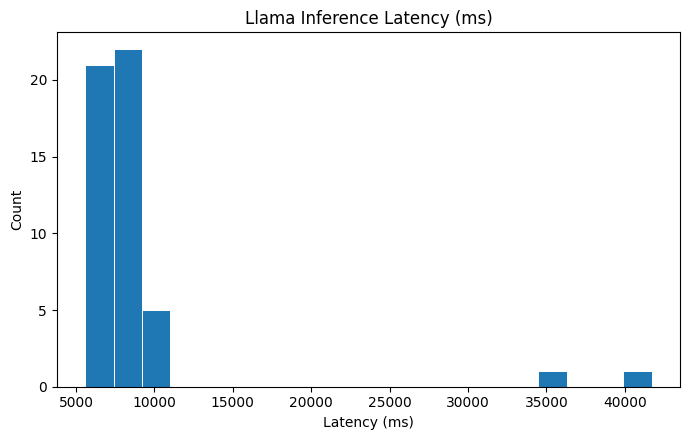

In [37]:
if "final_latency_ms" in llamaScores.columns:
    plt.figure(figsize=(7, 4.5))
    plt.hist(
        llamaScores["final_latency_ms"].dropna(),
        bins=20,
        edgecolor="white",   # <-- crisp separation
        linewidth=0.7
    )
    plt.title("Llama Inference Latency (ms)")
    plt.xlabel("Latency (ms)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


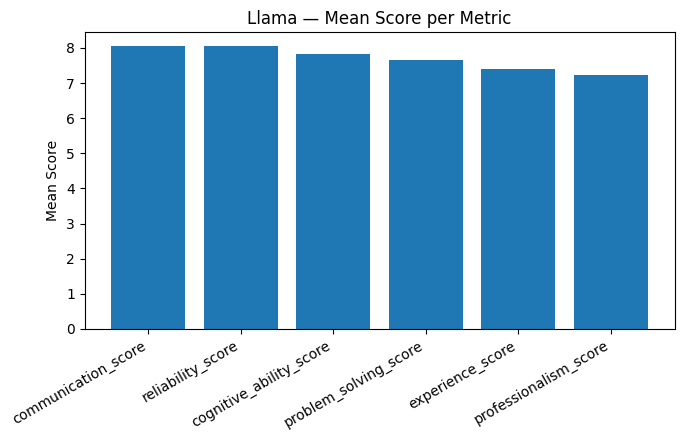

In [27]:
means = llamaScores[SCORE_COLS].mean().sort_values(ascending=False)

plt.figure(figsize=(7,4.5))
plt.bar(means.index, means.values)
plt.title("Llama — Mean Score per Metric")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Mean Score")
plt.tight_layout()
plt.show()

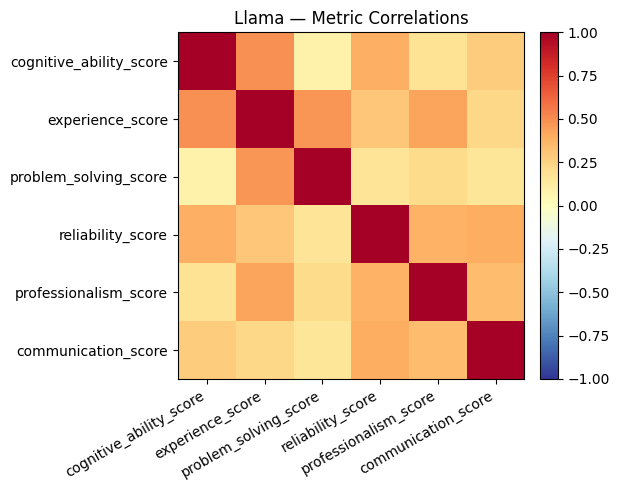

In [38]:
corr = llamaScores[SCORE_COLS].corr(numeric_only=True)

plt.figure(figsize=(6, 5))
im = plt.imshow(
    corr,
    vmin=-1,
    vmax=1,
    cmap="RdYlBu_r"  # softer/pastel diverging palette
)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(
    ticks=np.arange(len(SCORE_COLS)),
    labels=SCORE_COLS,
    rotation=30,
    ha="right"
)
plt.yticks(
    ticks=np.arange(len(SCORE_COLS)),
    labels=SCORE_COLS
)
plt.title("Llama — Metric Correlations")
plt.tight_layout()
plt.show()


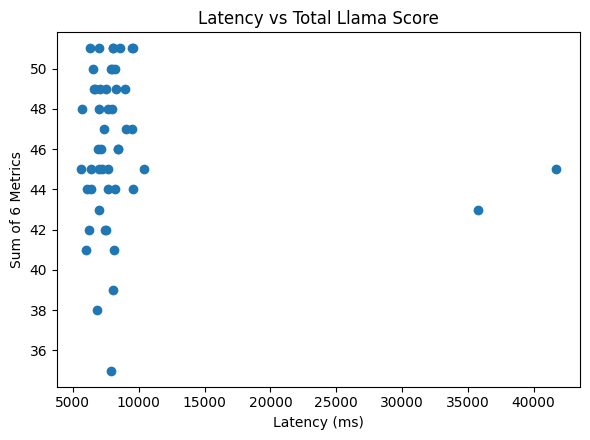

Correlation (latency vs total score): -0.08538070424972011


In [35]:
if "final_latency_ms" in llamaScores.columns:
    llamaScores["total_llama_score"] = llamaScores[SCORE_COLS].sum(axis=1, numeric_only=True)
    mask = (~llamaScores["final_latency_ms"].isna()) & (~llamaScores["total_llama_score"].isna())
    xv = llamaScores.loc[mask, "final_latency_ms"]
    yv = llamaScores.loc[mask, "total_llama_score"]

    plt.figure(figsize=(6,4.5))
    plt.scatter(xv, yv)
    plt.title("Latency vs Total Llama Score")
    plt.xlabel("Latency (ms)")
    plt.ylabel("Sum of 6 Metrics")
    plt.tight_layout()
    plt.show()

    corr_lat = np.corrcoef(xv, yv)[0,1] if len(xv) > 1 else np.nan
    print("Correlation (latency vs total score):", corr_lat)


## Comparitive Analysis <a name="comparative"></a>

In [22]:
def to_long(df, source_name):
    rows = []
    for _, r in df.iterrows():
        for metric in ["cognitive_ability", "experience", "problem_solving", "reliability", "professionalism", "communication"]:
            rows.append({
                "interview_id": r["interview_id"],
                "candidate_id": r.get("candidate_id"),
                "role_title": r.get("role_title"),
                "metric": metric,
                "score": r.get(f"{metric}_score"),
                "justification": r.get(f"{metric}_justification"),
                "source": source_name
            })
    return pd.DataFrame(rows)

long_llama = to_long(llamaScores, "llama")
long_recruiter = to_long(recruiter, "recruiter")
long_service_owner = to_long(service_owner, "service_owner")

long_all = pd.concat([long_llama, long_recruiter, long_service_owner], ignore_index=True)


In [23]:
# Pivot to wide by source to compare scores side-by-side
wide = long_all.pivot_table(
    index=["interview_id", "metric"],
    columns="source",
    values="score",
    aggfunc="first"  # there should be one per (id, metric, source)
).reset_index()

# Compute deltas (where available)
for src in ["recruiter", "service_owner"]:
    wide[f"delta_{src}_minus_llama"] = wide[src] - wide["llama"]

def rmse(a, b):
    mask = (~pd.isna(a)) & (~pd.isna(b))
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(((a[mask] - b[mask]) ** 2).mean())

# Per-metric stats
records = []
for metric, g in wide.groupby("metric"):
    row = {"metric": metric}
    # recruiter vs llama
    if {"llama", "recruiter"}.issubset(g.columns):
        row["corr_llama_recruiter"] = g[["llama", "recruiter"]].corr().iloc[0,1]
        row["mae_llama_recruiter"] = (g["llama"] - g["recruiter"]).abs().mean()
        row["rmse_llama_recruiter"] = rmse(g["llama"], g["recruiter"])
        row["mean_delta_recruiter_minus_llama"] = g["recruiter"].sub(g["llama"]).mean()
    # service owner vs llama
    if {"llama", "service_owner"}.issubset(g.columns):
        row["corr_llama_service_owner"] = g[["llama", "service_owner"]].corr().iloc[0,1]
        row["mae_llama_service_owner"] = (g["llama"] - g["service_owner"]).abs().mean()
        row["rmse_llama_service_owner"] = rmse(g["llama"], g["service_owner"])
        row["mean_delta_service_owner_minus_llama"] = g["service_owner"].sub(g["llama"]).mean()
    records.append(row)

compare_summary = pd.DataFrame(records).sort_values("metric")
print(compare_summary)


              metric  corr_llama_recruiter  mae_llama_recruiter  \
0  cognitive_ability              0.088219                 2.98   
1      communication              0.118635                 3.20   
2         experience              0.194112                 1.60   
3    problem_solving              0.172018                 1.10   
4    professionalism              0.005857                 1.14   
5        reliability              0.005704                 2.24   

   rmse_llama_recruiter  mean_delta_recruiter_minus_llama  \
0              3.349627                             -2.94   
1              3.364521                             -3.16   
2              1.928730                             -1.52   
3              1.407125                             -0.78   
4              1.516575                             -0.34   
5              2.521904                             -2.16   

   corr_llama_service_owner  mae_llama_service_owner  \
0                 -0.157171                   

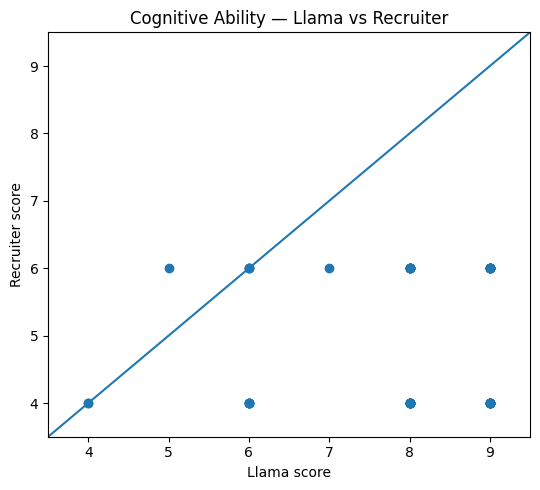

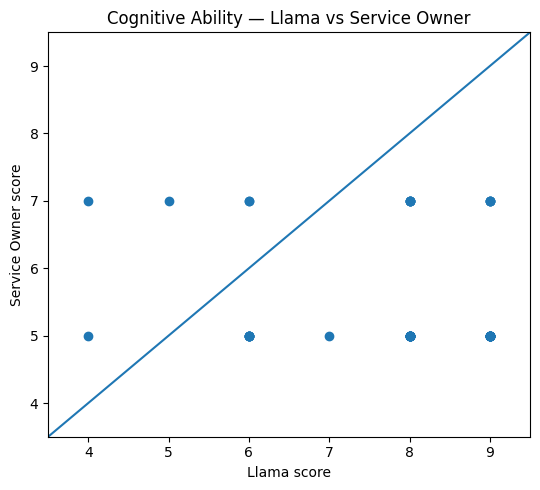

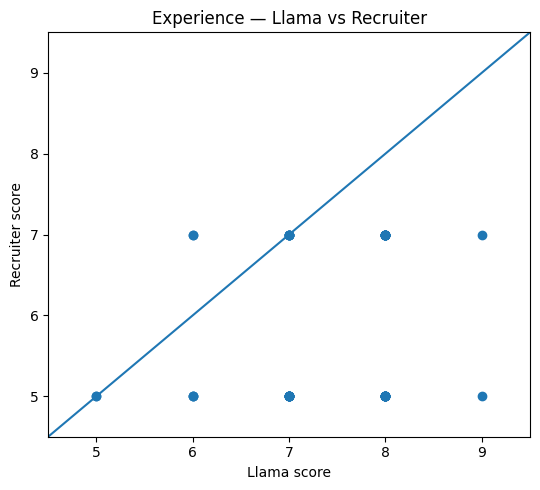

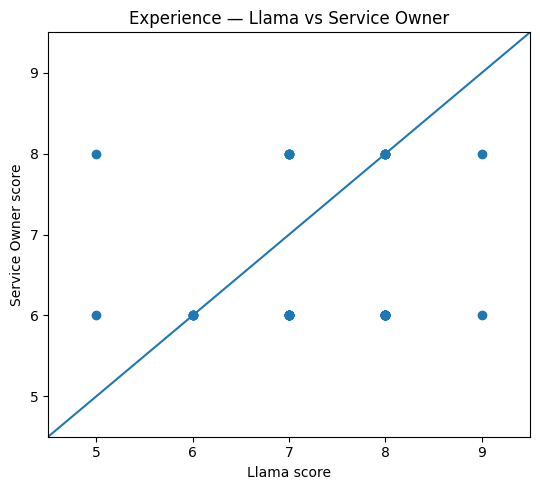

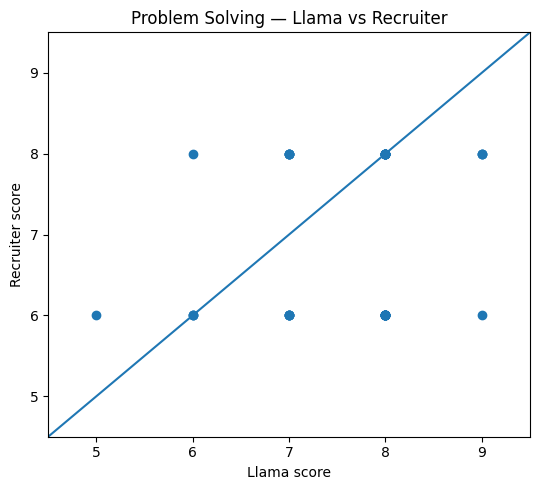

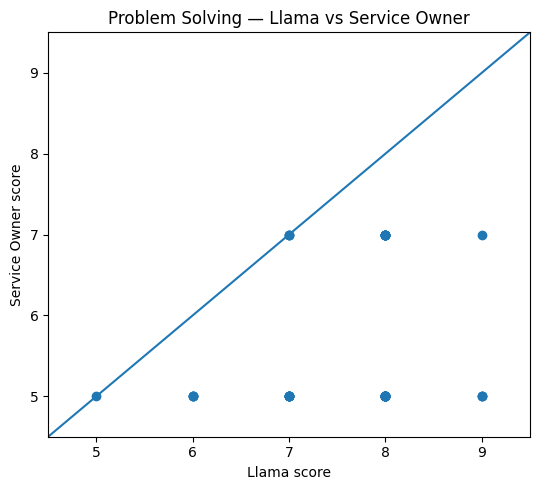

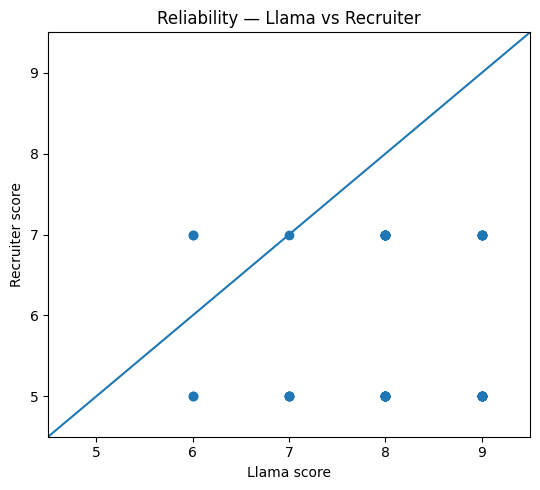

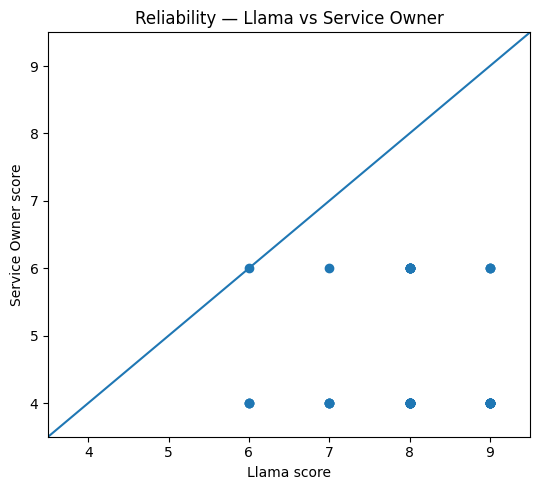

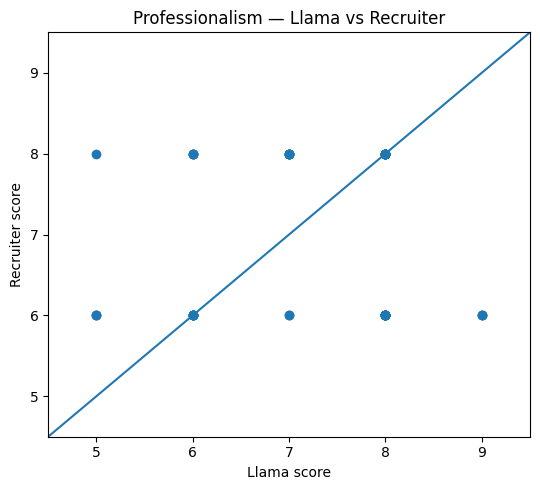

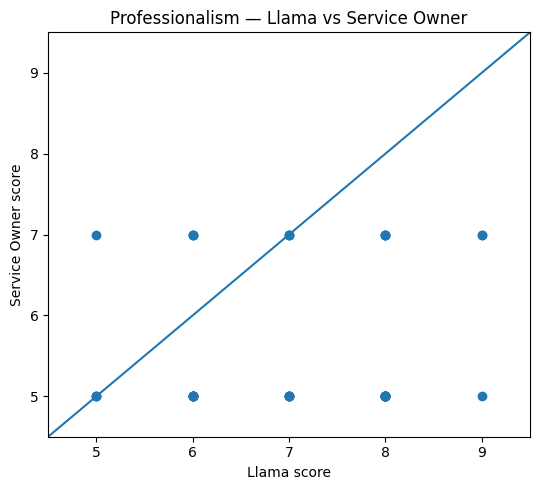

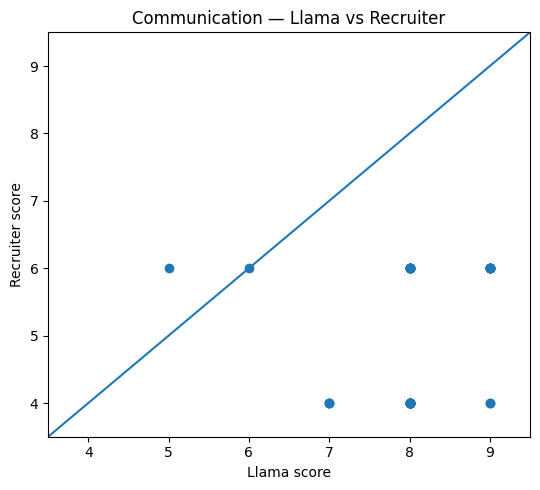

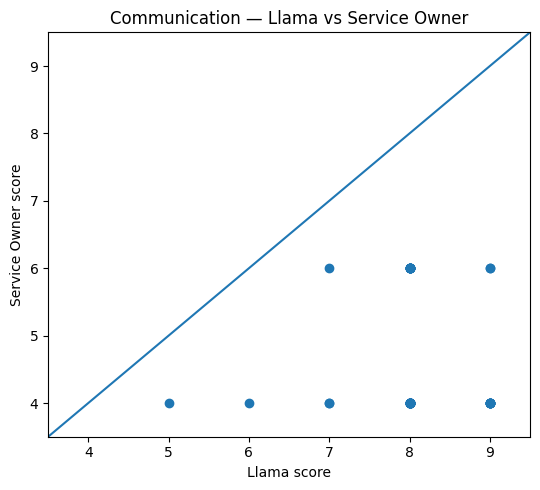

In [30]:
def scatter_vs_human(metric_snake, human_col, title_suffix):
    x = wide["llama"]
    y = wide[human_col]
    mask = (wide["metric"] == metric_snake) & (~x.isna()) & (~y.isna())
    if mask.sum() == 0:
        print(f"No data for {metric_snake} ({title_suffix})")
        return
    xv = x[mask]; yv = y[mask]

    plt.figure(figsize=(5.5,5))
    plt.scatter(xv, yv)
    mn, mx = min(xv.min(), yv.min())-0.5, max(xv.max(), yv.max())+0.5
    plt.plot([mn, mx], [mn, mx])  # y = x reference
    plt.title(f"{metric_snake.replace('_',' ').title()} — Llama vs {title_suffix}")
    plt.xlabel("Llama score")
    plt.ylabel(f"{title_suffix} score")
    plt.xlim(mn, mx); plt.ylim(mn, mx)
    plt.tight_layout()
    plt.show()

for metric in ["cognitive_ability", "experience", "problem_solving", "reliability", "professionalism", "communication"]:
    scatter_vs_human(metric, "recruiter", "Recruiter")
    scatter_vs_human(metric, "service_owner", "Service Owner")


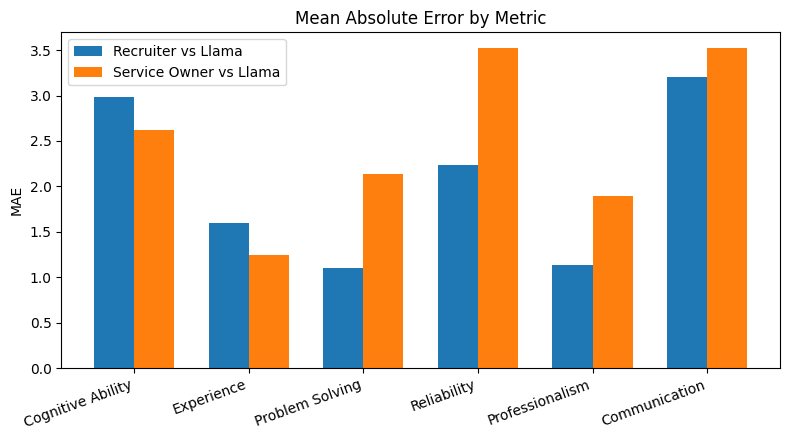

In [31]:
# Ensure metrics appear in a consistent order
order = ["cognitive_ability", "experience", "problem_solving", "reliability", "professionalism", "communication"]
cs = compare_summary.set_index("metric").reindex(order)

plt.figure(figsize=(8,4.5))
width = 0.35
idx = np.arange(len(order))
mae_rec = cs["mae_llama_recruiter"].values
mae_so  = cs["mae_llama_service_owner"].values

plt.bar(idx - width/2, mae_rec, width, label="Recruiter vs Llama")
plt.bar(idx + width/2, mae_so,  width, label="Service Owner vs Llama")

plt.xticks(idx, [m.replace("_"," ").title() for m in order], rotation=20, ha="right")
plt.ylabel("MAE")
plt.title("Mean Absolute Error by Metric")
plt.legend()
plt.tight_layout()
plt.show()


## Per-Candidate Disagreement Table <a name="disagreement"></a>

In [24]:
# Mean absolute deltas per interview
per_interview = wide.groupby("interview_id").agg({
    "delta_recruiter_minus_llama": lambda s: s.abs().mean(skipna=True),
    "delta_service_owner_minus_llama": lambda s: s.abs().mean(skipna=True),
}).rename(columns={
    "delta_recruiter_minus_llama": "mean_abs_delta_recruiter_vs_llama",
    "delta_service_owner_minus_llama": "mean_abs_delta_service_owner_vs_llama"
}).reset_index().sort_values("mean_abs_delta_recruiter_vs_llama", ascending=False)

per_interview.head(10)

source,interview_id,mean_abs_delta_recruiter_vs_llama,mean_abs_delta_service_owner_vs_llama
0,intv_0001,3.500000,3.666667
1,intv_0002,3.500000,1.666667
2,intv_0003,3.500000,1.666667
14,intv_0015,3.333333,3.500000
34,intv_0035,3.333333,3.500000
46,intv_0047,3.333333,3.500000
27,intv_0028,3.166667,3.333333
22,intv_0023,3.000000,3.166667
12,intv_0013,3.000000,3.166667
31,intv_0032,3.000000,3.166667


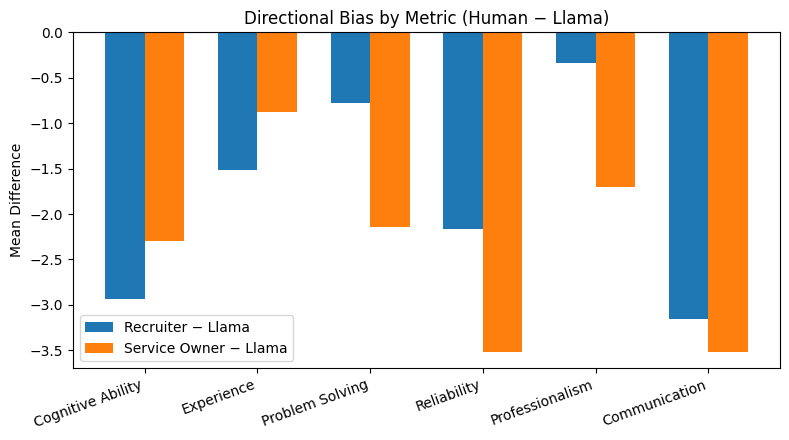

In [32]:
plt.figure(figsize=(8,4.5))
width = 0.35
idx = np.arange(len(order))
d_rec = cs["mean_delta_recruiter_minus_llama"].values
d_so  = cs["mean_delta_service_owner_minus_llama"].values

plt.bar(idx - width/2, d_rec, width, label="Recruiter − Llama")
plt.bar(idx + width/2, d_so,  width, label="Service Owner − Llama")

plt.axhline(0, linestyle="--")
plt.xticks(idx, [m.replace("_"," ").title() for m in order], rotation=20, ha="right")
plt.ylabel("Mean Difference")
plt.title("Directional Bias by Metric (Human − Llama)")
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# From earlier section (per_interview); if not created yet:
per_interview = wide.groupby("interview_id").agg({
    "delta_recruiter_minus_llama": lambda s: s.abs().mean(skipna=True),
    "delta_service_owner_minus_llama": lambda s: s.abs().mean(skipna=True),
}).rename(columns={
    "delta_recruiter_minus_llama": "mean_abs_delta_recruiter_vs_llama",
    "delta_service_owner_minus_llama": "mean_abs_delta_service_owner_vs_llama"
}).reset_index()

top10 = per_interview.sort_values("mean_abs_delta_recruiter_vs_llama", ascending=False).head(10)
display(top10)


source,interview_id,mean_abs_delta_recruiter_vs_llama,mean_abs_delta_service_owner_vs_llama
0,intv_0001,3.500000,3.666667
1,intv_0002,3.500000,1.666667
2,intv_0003,3.500000,1.666667
14,intv_0015,3.333333,3.500000
34,intv_0035,3.333333,3.500000
46,intv_0047,3.333333,3.500000
27,intv_0028,3.166667,3.333333
22,intv_0023,3.000000,3.166667
12,intv_0013,3.000000,3.166667
31,intv_0032,3.000000,3.166667
